**Start with this:**

Run the (***simple random search***) iteration

$$ u^+ = u - \frac{\gamma}{N} \sum_{n = 1}^N ( c(u + u_n) - c(u) ) \cdot u_n,\ u_n \sim \mathcal{N}(u,\sigma^2) $$

In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 


Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR^+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

---
TODO:
* add the computational backing that explains how this model has been derived
* also include all the equations from the Heliot paper
* talk about Legenstein model?
* add a table of contents!


In [12]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt


### Brain Modeling

In [13]:
###################
# Brain Model 
# Function that generates the adaptation

## INPUT
# lambda_vect = N x 3
# delta_perturb = N x 1
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_tarm = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3
def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
  # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
  num_neurons = np.size(lambda_vect.copy(), 0)
  targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
  # print("targ vect shape = " + str(np.shape(targ_vect_mult)))
  # print("targ vect mult = " + str(targ_vect_mult)) 

  targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3
  # print("targ_matx shape = " + str(np.shape(targ_matx)))
  # print("targ_matx = " + str(targ_matx))

  # next gradient term: \gamma*delta_perturb
  delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
  # print("delta_matx shape = " + str(np.shape(delta_matx)))
  # print("delta_matx = " + str(delta_matx))

  next_term = (delta_matx*targ_matx) # 3 x N
  # print("next_term shape = " + str(np.shape(next_term)))
  # print("next_term = " + str(next_term))

  lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
  return lambda_vect_new

## lambda, t --> f

## INPUT
# lambda_vect = N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
  # f = b + Fwt 
  targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
  newFR = np.matmul(lambda_vect, targ_vect_mult)
  return newFR

### Decoder Model

In [14]:
####################
# Decoder Model 

## firing rate --> a + Kf --> y
# K_matx = num neurons x num target 

def decoder_findY(decoder_params, input_fr, targ_vect):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
#     a_vect = a_vect_in.copy().reshape(np.size(targ_vect, 0),1)
#     k_matx = k_matx_in.copy().reshape(np.size(targ_vect, 0), np.size(input_fr, 0)) 
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    nextPred_vect = a_vect + np.dot(k_matx, np.squeeze(np.asarray(input_fr)))
    return (nextPred_vect)

# need:  (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
# grad_args_init = (decoder_init, fr_init)
# where decoder_init = (a_init, k_init)
def calcNextDecoder(decoder_params, fr_curr):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), fr_curr )
    # A = 2 x 1
    a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist, cost_func_args)
#     a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
    a_next = a_vect.copy().reshape(np.shape(a_grad))
    k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, cost_func_args)
    k_next = k_matx.copy() - k_rate*k_grad
#     k_next = k_matx.copy()
    return (a_next, k_next)

    
    

### Reach Error

In [15]:
####################
# Reach error

# y_x, y_y = matrix of predicted cursor position
# t_x, t_y = matrix of target position
def calcReachError(y_vect, t_vect):
  norm_vect = np.array(y_vect) - np.array(t_vect)
  return (np.linalg.norm(norm_vect, 2)**2)

## INPUT
# firing rate = vector  (N x 1)
## OUTPUT
# reach error = scalar
# def reachError_FR(firing_rate):
#   y_vect = decoder_findY(firing_rate, TARGET_VECTOR_ERR)
#   t_vect = TARGET_VECTOR_ERR
#   return calcReachError(y_vect, t_vect)  

def error_costFunc(cost_func_params):
    decoder_params, firing_rate = cost_func_params
    print("in error cost")
    print(decoder_params)
    y_vect = decoder_findY(decoder_params, firing_rate, TARGET_VECTOR_ERR)
    t_vect = TARGET_VECTOR_ERR
    return calcReachError(y_vect, t_vect)  

# def reachError_A_vector(a_new, *args):
#     decoder_params = 
#     nextPred_vect = a_vect + np.dot(k_matx, np.squeeze(np.asarray(input_fr)))
#     decoder_findY(decoder_params, input_fr, targ_vect)



### Stochastic Gradient Descent: Update Calculation

In [16]:
## Related to Stochastic Gradient Descent
# NOTE 03/18/20: Checked that this function returned the correct variables for N = 1 and N = 3

## INPUT
# this is only 1 iteration of SGD
# takes in vector fr_input [ N x 1]
## OUTPUT
# errorGrad = [N x 1]

def findErrorGrad(input_vect, input_var, param_dist, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, curr_fr) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.zeros((num_input_row, num_input_column, num_dist))
    
    
    for iC in range(num_input_column):
        for iN in range(num_input_row):
            perturb_rand[iN, iC, :] = np.random.normal(0, sigma, num_dist) 
            # perturb_rand = N_input x N_dist
            # for each iteration, np.random.normal returns a N_dist x 1 array
    
    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
#         perturb_vect = np.zeros((num_input_row, num_input_column))
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, input_perturb)         
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, input_fr)

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, input_fr)   
        
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = error_costFunc(perturb_cost_args)   
        error_input = error_costFunc(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad



### Stochastic Gradient Descent: Update Step and Recalculate Error

In [17]:
# param vect = what to update 
def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
    decoder_init = (a_init, k_init)
    grad_args_init = (decoder_init, fr_init)
    

    num_neurons = np.size(fr_init, 0)

    # Load display stuff
    figsize = (fig_x , fig_y)
    plt.figure(figsize=figsize)
    ax1 = plt.subplot(1,3,1); ax1.grid('on')
    ax2 = plt.subplot(1,3,2); ax2.grid('on')
    ax3 = plt.subplot(1,3,3); ax3.grid('on')
    runs_num = 1

    # for sigma in sigma_list:
    for iR in range(runs_num):
        # Set the u vectors
        fr_vect = np.zeros( (num_neurons, num_iter) )
        fr_vect[:, [0]] = fr_init #fr init = num_neurons x 1
        fr_final = np.zeros((num_neurons, runs_num))
        re_final = np.zeros(runs_num)
        lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

        print("starting fr vect = " + str(fr_vect[:, [0]]))
        # lambda init = N x 3
        # lambda_vect = N x 3 X ITER
        lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
        lambda_vect[:,:,0] = lambda_init 

        # set the cost vector
        err_vect = np.zeros(num_iter)
        err_vect[0] = error_costFunc(grad_args_init)
        print('initial error = ' + str(err_vect[0]))

        # calculate the initial delta e
        grad_new = np.zeros(num_iter)
        grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, grad_args_init)

        for iT in range(num_iter-1):
            ## calculate the new u 
            # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
            lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
            lambda_vect[:,:, iT + 1] = lambda_next
            
            #   # (2) fr+ = B(lambda+)
            fr_next = brainFiringRate(lambda_next, targ_vect)
            fr_vect[:, iT+1] = fr_next
            
#             # Update decoder as well
#             calcNextDecoder(a_param, a_rate, a_param_dist, k_param, k_rate, k_param_dist, curr_fr)
    
            # Update parameters for calculating error
    
              #   ## calculate the new cost
              #   # (3) Calculate the new reach error 
#             fr_update = fr_next.copy().reshape(num_neurons, 1)
            grad_args_next = (decoder_init, fr_next)
            err_next = np.array(error_costFunc(grad_args_next))
            err_vect[iT+1] = err_next
            print('next error = ' + str(err_next))


              #   ## calculate the next error descent term
            # to update FR again
            grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, grad_args_next)
        
        fr_final[:, iR] = fr_next
        re_final[iR] = err_next
        lambda_final[:, :, iR] = lambda_next
        ax1.plot(range(num_iter), err_vect, label=fr_sigma)
        
        
        for iN in range(num_neurons):
            ax2.plot(range(num_iter), fr_vect[iN, :], label=fr_sigma)  
#             ax3.plot(range(numIter), lambda_vect[iN, 0, :], label = 'b') 
            ax3.plot(range(num_iter), lambda_vect[iN, 1, :], label = 'Wx, sigma =' + str(fr_sigma)) 
            # ax3.plot(range(numIter), lambda_vect[iN, 2, :], label = 'Wy, sigma =' + str(fr_sigma))

        # # Draw results
        ax1.set_ylabel('$RE$', color='white')
        ax1.set_xlabel('iteration', color='white')
        ax1.tick_params(axis='x', colors='white')
        ax1.tick_params(axis='y', colors='white')
        ax1.set_title('RE' + ' N = ' + str(fr_dist_size) + ' Rate = ' + str(lambda_rate), color='white')
        ax1.legend()

        # # ax2.plot(range(it_num),u_new)
        ax2.set_ylabel('$FR$', color='white')
        ax2.set_xlabel('iteration', color='white')
        ax2.tick_params(axis='x', colors='white')
        ax2.tick_params(axis='y', colors='white')
        ax2.set_title('FR', color='white')
        ax2.legend()

        ax3.set_ylabel('$lambda$', color='white')
        ax3.set_xlabel('iteration', color='white')
        ax3.tick_params(axis='x', colors='white')
        ax3.tick_params(axis='y', colors='white')
        ax3.set_title('Lambda', color='white')
        ax3.legend()

#     print("FR = " + str(fr_final))
#     print("diff in FR = " + str(fr_final - fr_init))
#     print("final lambda = " + str(lambda_final))
#     print("RE = " + str(re_final))
    
    return (re_final, fr_final, lambda_final)

### Stochastic Gradient Descent: Update Brain + Adapter and Recalculate Error

In [18]:
def brain_decoder_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
    decoder_init = (a_init, k_init)
    grad_args_init = (decoder_init, fr_init)
    

    num_neurons = np.size(fr_init, 0)

    # Load display stuff
    figsize = (fig_x , fig_y)
    plt.figure(figsize=figsize)
    ax1 = plt.subplot(1,3,1); ax1.grid('on')
    ax2 = plt.subplot(1,3,2); ax2.grid('on')
    ax3 = plt.subplot(1,3,3); ax3.grid('on')
    runs_num = 1

    # for sigma in sigma_list:
    for iR in range(runs_num):
        # Set the u vectors
        fr_vect = np.zeros( (num_neurons, num_iter) )
        fr_vect[:, [0]] = fr_init #fr init = num_neurons x 1
        fr_final = np.zeros((num_neurons, runs_num))
        re_final = np.zeros(runs_num)
        lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

        print("starting fr vect = " + str(fr_vect[:, [0]]))
        # lambda init = N x 3
        # lambda_vect = N x 3 X ITER
        lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
        lambda_vect[:,:,0] = lambda_init 

        # set the cost vector
        err_vect = np.zeros(num_iter)
        err_vect[0] = error_costFunc(grad_args_init)
        print('initial error = ' + str(err_vect[0]))

        # calculate the initial delta e
        grad_new = np.zeros(num_iter)
        grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, grad_args_init)

        for iT in range(num_iter-1):
            ## calculate the new u 
            # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
            lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
            lambda_vect[:,:, iT + 1] = lambda_next
            
            #   # (2) fr+ = B(lambda+)
            fr_next = brainFiringRate(lambda_next, targ_vect)
            fr_vect[:, iT+1] = fr_next
            
#             # Update decoder as well
#             calcNextDecoder(a_param, a_rate, a_param_dist, k_param, k_rate, k_param_dist, curr_fr)
    
            # Update parameters for calculating error
    
              #   ## calculate the new cost
              #   # (3) Calculate the new reach error 
#             fr_update = fr_next.copy().reshape(num_neurons, 1)
            grad_args_next = (decoder_init, fr_next)
            err_next = np.array(error_costFunc(grad_args_next))
            err_vect[iT+1] = err_next
            print('next error = ' + str(err_next))

              #   ## calculate the next error descent term
            # to update FR again
            grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, grad_args_next)
        
        fr_final[:, iR] = fr_next
        re_final[iR] = err_next
        lambda_final[:, :, iR] = lambda_next
        ax1.plot(range(num_iter), err_vect, label=fr_sigma)
        
        
        for iN in range(num_neurons):
            ax2.plot(range(num_iter), fr_vect[iN, :], label=fr_sigma)  
#             ax3.plot(range(numIter), lambda_vect[iN, 0, :], label = 'b') 
            ax3.plot(range(num_iter), lambda_vect[iN, 1, :], label = 'Wx, sigma =' + str(fr_sigma)) 
            # ax3.plot(range(numIter), lambda_vect[iN, 2, :], label = 'Wy, sigma =' + str(fr_sigma))

        # # Draw results
        ax1.set_ylabel('$RE$', color='white')
        ax1.set_xlabel('iteration', color='white')
        ax1.tick_params(axis='x', colors='white')
        ax1.tick_params(axis='y', colors='white')
        ax1.set_title('RE' + ' N = ' + str(fr_dist_size) + ' Rate = ' + str(lambda_rate), color='white')
        ax1.legend()

        # # ax2.plot(range(it_num),u_new)
        ax2.set_ylabel('$FR$', color='white')
        ax2.set_xlabel('iteration', color='white')
        ax2.tick_params(axis='x', colors='white')
        ax2.tick_params(axis='y', colors='white')
        ax2.set_title('FR', color='white')
        ax2.legend()

        ax3.set_ylabel('$lambda$', color='white')
        ax3.set_xlabel('iteration', color='white')
        ax3.tick_params(axis='x', colors='white')
        ax3.tick_params(axis='y', colors='white')
        ax3.set_title('Lambda', color='white')
        ax3.legend()

#     print("FR = " + str(fr_final))
#     print("diff in FR = " + str(fr_final - fr_init))
#     print("final lambda = " + str(lambda_final))
#     print("RE = " + str(re_final))
    
    return (re_final, fr_final, lambda_final)

### Run through trials, set initial conditions

K MATX INIT= [[0.10115714 0.02872349 0.45777826 0.22379486]
 [0.37955661 0.38623679 0.25790971 0.39602529]]
A VECT INIT = [ -8.13559162 -12.54930254]
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
re init = 0.0
in error cost
(array([[ -7.84584136],
       [-13.11220158]]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([[ -8.62840808],
       [-12.61032527]]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0

in error cost
(array([[ -9.50405658],
       [-14.2323735 ]]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([[ -7.29504508],
       [-13.00737084]]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([[ -8.25017807],
       [-10.95879979]]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661

       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([[ -8.32341229],
       [-11.59441323]]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([[ -7.77765817],
       [-12.2192967 ]]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([[ -7.28768521],
       [-14.09765754]]), array([[0.101157

       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[-0.70715331, -0.88625237, -1.30098783,  1.87155708],
       [ 0.49411435,  1.32272834, -0.89489209,  1.53147265]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[ 0.4150079 ,  1.18790234,  0.24178642,  0.73657493],
       [ 2.07055751,  1.1275122 , -0.59307905,  0.45190543]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[ 1.1888516 , -0.83624598,  1.20696309,  1.56289744],
       [-0.20172705, -0.93672955, -0.36722062, -0.66103811]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.028

in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[ 0.17498594, -0.97669821,  0.08613681, -0.32028587],
       [ 0.8042152 ,  0.93175746,  0.08270746,  1.36487993]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[ 0.68909874, -0.06741647, -1.66083786,  2.0140705 ],
       [ 0.45596434, -0.49190474,  1.12520749,  1.32481662]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[0.10115714, 0.02872349, 0.45777826, 0.22379486],
       [0.37955661, 0.38623679, 0.25790971, 0.39602529]]))
in error cost
(array([ -8.13559162, -12.54930254]), array([[-0.90402251,  0.99583251,  0.92086455,  1.33782068],
       [-0.15065697,  1.0723247

       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.52837398],
       [-12.89339425]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -7.85493133],
       [-11.46324813]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in

(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -9.36002376],
       [-14.29123227]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -7.29718115],
       [-12.62354666]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.44757178],
       [-10.39919519]]), array([[ 0.10525

in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[-0.53302174,  0.32160469,  1.89395948, -0.28749407],
       [-0.49683703,  0.36053499, -0.47454085,  2.20094328]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[-0.38041822,  0.21063256, -0.23096516, -0.4324998 ],
       [ 1.01753708,  1.04909138, -0.29325186, -0.15637094]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[-1.70963959, -0.68994142,  1.07285395, -1.99537254],
       [ 0.18906463,  0.05986921,  1.17742165,  0.15953711]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), ar

       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 1.45166934, -0.86912588, -0.33455242,  0.01215036],
       [ 0.83313606, -2.5582454 ,  1.05410246,  1.89452404]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 1.74042014, -1.69902813,  1.47618385, -1.17083417],
       [ 0.49661621, -0.79754135, -1.5112815 ,  0.87839154]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.10525354,  0.02996626,  0.41828821, -0.0961658 ],
       [ 0.60103362,  0.41720968,  0.40109169,  0.43560592]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 1.09011537,  1.81845495,  0.89907018, -0.29024009],
       [-0.92692997, -0.79572099,  0.73097023,  1.4721238 ]]))
in

       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.35573432],
       [-12.1300805 ]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -7.83653722],
       [-14.78612136]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.87943247],
       [

       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -7.93399939],
       [-11.76384155]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -9.8933318 ],
       [-10.95905685]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -9.20851038],
       [

       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -7.21782601],
       [-14.5388321 ]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -7.90275319],
       [-13.7922038 ]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.7662982 ],
       [

       [ 0.70720062,  0.84243784, -0.06733896,  1.40839659]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 1.37411263, -0.98735121,  1.98815221,  0.74639607],
       [ 1.0913571 ,  0.03026111,  2.12849094,  1.15390043]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 0.26498872,  0.8762333 ,  1.77927657,  0.86262443],
       [-0.66228732,  0.67634423, -0.79345865, -2.2736291 ]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8

(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[-0.20988333, -0.22520369,  2.30862003,  0.58861702],
       [ 1.74351976, -0.58311191,  0.02157326,  0.37199521]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[-0.60343672,  0.58942684,  1.15952735,  1.39483549],
       [ 0.58459571,  2.87589057,  1.65876278,  0.92361823]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[0.45838026, 0.29663533, 0.79409085, 0.5790561 ],
       [0.51827552, 0.58009956, 0.71112014, 0.17376699]]))
in error cost
(array([[ -8.13559162],
       [-12.54930254]]), array([[ 1.81754062, -0.29748044,  0.107

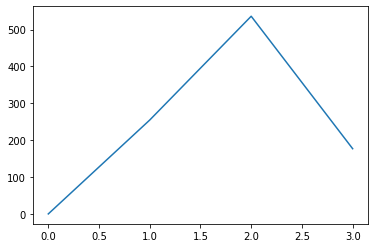

In [19]:

########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = N x 1
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

BASELINE = np.array([5, 10, 15, 20])
NUM_NEURONS = len(BASELINE)
NUM_ITER = 50

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 
fr_init[:, 0] = np.array(BASELINE)

# lambda
lambda_init = np.zeros((NUM_NEURONS, 3))
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_y

# target position
TARGET_VECTOR = np.array( [2 ,3])
TARGET_ERROR = np.array([2, 2])
TARGET_VECTOR_ERR = TARGET_VECTOR + TARGET_ERROR

# decoder initial paramters
K_MATX = np.random.random_sample( (2, NUM_NEURONS) ) # random float [0, 1)
A_VECT = (TARGET_VECTOR_ERR - np.matmul(K_MATX, BASELINE))

# SGD initial parameters
# IMPORTANT!
FR_VAR = 1
A_VAR = 2
K_VAR = 3
# Brain
rate_list = [5e-3, 1e-3, 5e-4]
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
A_RATE = 1e-1
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 16
fig_y = 4

## testing decoder functions
# print("FR shape = " + str(np.shape(fr_init)))
# print("FR init = " + str(fr_init))
# # print(np.shape(K_MATX))

# # fr_test = np.zeros((NUM_NEURONS, NUM_ITER))
# # fr_next = brainFiringRate(lambda_init, TARGET_VECTOR).reshape(4,1)
# # fr_test[:, [0]] = fr_next
# # print("fr next shape = " + str(np.shape(fr_next)))
# # print("fr next  = " + str(fr_test[:, 0] ))


print("K MATX INIT= " + str(K_MATX))
# print(np.matmul(K_MATX, BASELINE))
print("A VECT INIT = " + str(A_VECT))
    ## DECODER SIDE
A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)
decoder_params_init = (A_VECT, A_RATE, A_DIST, K_MATX, K_RATE, K_DIST)
    
test_runs = 4
a_new = np.zeros((test_runs, 2, 1))
error = np.zeros(test_runs)
decoder_params = decoder_params_init
dec_init = (A_VECT, K_MATX)
print("re init = " + str(error_costFunc((dec_init, fr_init))))


for iT in range(test_runs-1):
#     print(iT)
    (a_next, k_next) = calcNextDecoder(decoder_params, fr_init)
    print("a next = " + a_next)
    print(k_next)
    decoder_params = (a_next, A_RATE, A_DIST, k_next, K_RATE, K_DIST)
    a_new[iT+1, :, :] = a_next
    decoder_next = (a_next, k_next)
    cost_func_params = (decoder_next, fr_init)
    error[iT+1] = error_costFunc(cost_func_params)
#     print("re = " + str(error[iT+1]))
#     print("K next = " + str(k_new - K_MATX))
#     print("A next = " + str(a_new[iT, :, :]))
#     print("")

# print("a final = " + str(a_next))
plt.plot(range(test_runs), error[:])
plt.show()
# plt.plot(range(test_runs), a_new[:, 0, :], '.')
# plt.show()
# plt.plot(range(test_runs), a_new[:, 1, :], '.')
# plt.show()   


# print("y from decoder = " + str(decoder_findY(fr_next, TARGET_VECTOR)))
# print("error from init = " + str(reachError_FR(fr_next, TARGET_VECTOR)))


# curr_fr = fr_next
# a_param_dist = (A_SIGMA, A_DELTA, A_DIST)
# k_param_dist = (K_SIGMA, K_DELTA, K_DIST)
# update_args = (curr_fr, NUM_NEURONS)
# a_calc, k_calc = calcNextDecoder(A_VECT, A_RATE, a_param_dist, K_MATX, K_RATE, k_param_dist, update_args)
# print("a calc = " + str(a_calc))
# print("K matx = " + str(k_calc))

# # testing error gradient function
# # print("FR init = " + str(fr_init))
# deltaE_vect = findErrorGrad_fr(fr_next, 1, 1, TARGET_VECTOR, 3)
# print("delta E vect = " + str(deltaE_vect))

##  testing lambda
# print("initial lambda = " + str(lambda_init))
# print("initial lambda shape = " + str(np.shape(lambda_init)))
# delta_perturb = np.ones((NUM_NEURONS, 1))*0.2
# lambda_next = calcNextLambda(lambda_init, 1, delta_perturb, TARGET_VECTOR)
# print("lambda next = " + str(lambda_next))



# for rate in rate_list:
#     ## BRAIN SIDE
#     # (sigma, delta, num_dist) = param_dist
#     FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
#     #(fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     brain_params_init = (fr_init, FR_DIST, lambda_init, rate)
    
#     ## DECODER SIDE
#     A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
#     K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)
#     decoder_params_init = (A_VECT, A_RATE, A_DIST, K_MATX, K_RATE, K_DIST)
    
#     print("=================================")
#     print("rate = " + str(rate))
#     (re_final, fr_final, lambda_final) = brain_adapt_sgd(brain_params_init, decoder_params_init, TARGET_VECTOR_ERR, NUM_ITER)
    
#     print("FR = " + str(fr_final))
# #     print("diff in FR = " + str(fr_final - fr_init))
#     print("final lambda = " + str(lambda_final))
#     print("RE = " + str(re_final))
    
    
#     print("=================================")
#     print("rate = " + str(rate))
#     brain_params2 = (fr_final, FR_DIST, np.squeeze(lambda_final), rate)
#     TARGET_VECTOR_ERR =  np.array([4, 4])
#     (re_final_2, fr_final_2, lambda_final_2) = brain_adapt_sgd(brain_params2, decoder_params_init, TARGET_VECTOR_ERR, NUM_ITER)
#     print("FR = " + str(fr_final_2))
# #     print("diff in FR = " + str(fr_final - fr_init))
#     print("final lambda = " + str(lambda_final_2))
#     print("RE = " + str(re_final_2))
    